In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from backtesting_engine import BacktestEngine
from typing import Dict, Any
from matplotlib import pyplot as plt
import pandas as pd
import csv
from datetime import datetime, timedelta

In [2]:
class oi_strategy(BacktestEngine):
    def __init__(self, config: Dict[str, Any]):
        super().__init__(config)
        self.CE_open_interest = []
        self.PE_open_interest = []
        self.oi_ratio = []
        self.position = False

        self.atm_ticks = {}
        return
    
    def get_atm_strike(self,date):
        data=self.kite.historical_data(256265, self.config['start_date'], self.config['start_date'], "minute")
        index=0
        for i in data:
            if i['date'] == date:
                index = i['close']
                break
        strike = round(index/50) * 50

        return strike

    def update_bars(self, new_bars):
        print(f"Updating {new_bars[0].date} bars")
        CE_oi = 0
        PE_oi = 0

        atm_strike = self.get_atm_strike(new_bars[0].date)

        for b in new_bars:
            # print(f"Updating bar: {b.date} for instrument {self.trading_symbols[b.instrument_token]}")
            if self.trading_symbols[b.instrument_token][-2:] == 'CE':
                CE_oi += b.oi
            elif self.trading_symbols[b.instrument_token][-2:] == 'PE':
                PE_oi += b.oi

            if float(self.trading_symbols[b.instrument_token][-7:-2]) == atm_strike:
                self.atm_ticks[b.instrument_token] = b
            # self.check_all_conditions()
            # open_interest += b.oi
            # self.check_all_conditions()
        self.CE_open_interest.append(CE_oi)
        self.PE_open_interest.append(PE_oi)
        self.oi_ratio.append(-CE_oi/PE_oi)
        # print(self.atm_ticks)
        print(f"Call oi: {CE_oi}, Put oi: {PE_oi}, OI ratio: {CE_oi/PE_oi}")
        with open (self.oi_data,'a') as file:
            writer = csv.writer(file)
            writer.writerow([new_bars[0].date, CE_oi, PE_oi, -CE_oi/PE_oi])
        self.check_all_conditions()

    def setup_directories(self):
        # super().setup_directories()
        folder_path=os.path.join(os.getcwd(),'oi_data')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        path= self.config['start_date'] + '_' + 'oi_data.csv'
        self.oi_data=os.path.join(folder_path,path)
        if not os.path.exists(self.oi_data):
            pd.DataFrame(columns=['timestamp', 'Call oi','Put oi','Inverse OI_ratio']).to_csv(self.oi_data, index=False)
        return
    
    def log_positions(self, timestamp):
        return

    def calculate_change_oi(self):
        if len(self.oi_ratio)<2:
            return None
        change = (self.oi_ratio[-2]-self.oi_ratio[-1])/self.oi_ratio[-2] * 100
        print(change)
        return change


    def check_all_conditions(self):
        # Implement your strategy conditions here
        # change = self.calculate_change_oi()
        # if change is not None:
        #     if change>0.002 and not self.position:
        #         tokens = self.instruments_NFO[self.instruments_NFO['instrument_tokens'].isin(list(self.atm_ticks.keys()))]
        #         expiry = sorted(tokens['expiry'].unique())
        #         token=tokens[tokens['expiry']==expiry[0]]['instrument_token'].values
        #         try:
        #             for tk in token:
        #                 if self.trading_symbols[self.atm_ticks['instrument_token']][-2:] == 'CE':
        #                     self.place_order(self.atm_ticks[token],1,'BUY',self.atm_ticks[token].close)
        #                 elif self.trading_symbols[self.atm_ticks['instrument_token']][-2:] == 'PE':
        #                     self.place_order(self.atm_ticks[token],1,'SELL',self.atm_ticks[token].close)
        #             self.position = True
        #         except Exception as e:
        #             # continue
        #             print(e)
        #     elif change<-0.002 and not self.position:
        #         tokens = self.instruments_NFO[self.instruments_NFO['instrument_tokens'].isin(list(self.atm_ticks.keys()))]
        #         expiry = sorted(tokens['expiry'].unique())
        #         token=tokens[tokens['expiry']==expiry[0]]['instrument_token'].values
        #         try:
        #             for tk in token:
        #                 if self.trading_symbols[self.atm_ticks['instrument_token']][-2:] == 'CE':
        #                     self.place_order(self.atm_ticks[token],1,'BUY',self.atm_ticks[token].close)
        #                 elif self.trading_symbols[self.atm_ticks['instrument_token']][-2:] == 'PE':
        #                     self.place_order(self.atm_ticks[token],1,'SELL',self.atm_ticks[token].close)
        #         except Exception as e:
        #             # continue
        #             print(e)

        pass


In [3]:
s='NIFTY25MAY24500CE'
s[-7:-2]

'24500'

In [4]:
st_date='2025-05-30'
en_date='2025-05-30'

start = datetime.strptime(st_date, "%Y-%m-%d")
end = datetime.strptime(en_date, "%Y-%m-%d")

# Generate list of date strings
all_dates = [(start + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end - start).days + 1)]

token_instance = BacktestEngine({'strategy_name': 'abc'})

instrument_tokens = token_instance.get_NFO_tokens(tradingsymbols=['NIFTY'],expiry_codes=[0,1,2,3],types=['CE','PE'])

for date in all_dates:
    strategy_name = "oi_strategy" + date
    config={
        "strategy_name": "oi_strategy",
        "start_date": date,
        "end_date": date,
        # "NFO_symbols":['NIFTY'],
        # "NFO_types":['CE','PE'],
        # "NFO_expiry_codes":[0,1,2,3],
        "tokens":instrument_tokens,
        "interval": "minute",
    }


    try:
        sample = oi_strategy(config)
        sample.run()
    except Exception as e:
        continue

# plt.plot(sample.oi_ratio)
# plt.show()

No trading symbols provided for NFO tokens.
No trading symbols provided for NSE tokens.
No trading symbols provided for BSE tokens.
No trading symbols provided for BFO tokens.
Expiries for NIFTY: [datetime.date(2025, 6, 5), datetime.date(2025, 6, 12), datetime.date(2025, 6, 19), datetime.date(2025, 6, 26), datetime.date(2025, 7, 3), datetime.date(2025, 7, 31), datetime.date(2025, 8, 28), datetime.date(2025, 9, 25), datetime.date(2025, 12, 24), datetime.date(2026, 3, 26), datetime.date(2026, 6, 25), datetime.date(2026, 12, 31), datetime.date(2027, 6, 24), datetime.date(2027, 12, 30), datetime.date(2028, 6, 29), datetime.date(2028, 12, 28), datetime.date(2029, 6, 28), datetime.date(2029, 12, 27)]
Expiry codes for NIFTY: {0: datetime.date(2025, 6, 5), 1: datetime.date(2025, 6, 12), 2: datetime.date(2025, 6, 19), 3: datetime.date(2025, 6, 26), 4: datetime.date(2025, 7, 3), 5: datetime.date(2025, 7, 31), 6: datetime.date(2025, 8, 28), 7: datetime.date(2025, 9, 25), 8: datetime.date(2025, 12

In [35]:
token_instance.kite.historical_data(256265, "2025-05-30", "2025-05-30", "minute")

TokenException: Incorrect `api_key` or `access_token`.

<Axes: >

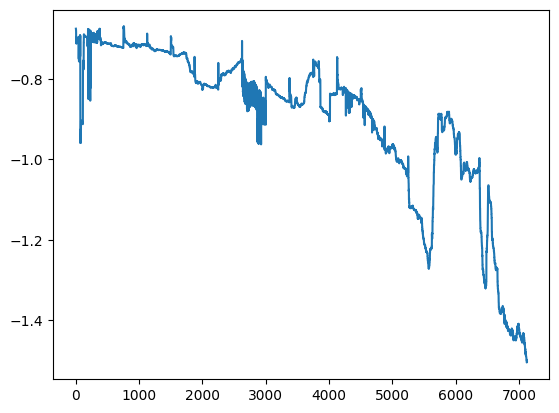

In [35]:
df=pd.read_csv('oi_data.csv')
df['Inverse OI_ratio'].plot()

<Axes: >

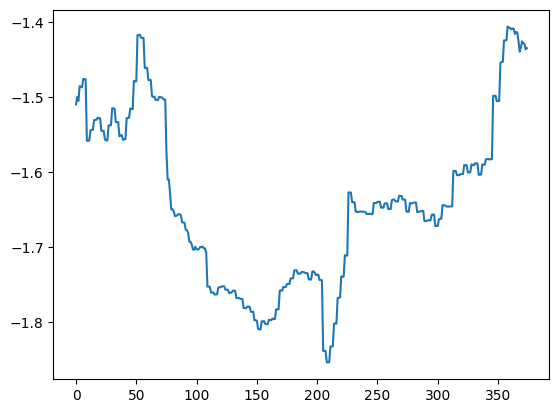

In [ ]:
ratio = pd.read_csv('/Users/sushrutkagde/Documents/Project_X/backtesting_framework/oi_strategy/oi_data/2025-05-29_oi_data.csv')
options = 
# ratio['Inverse OI_ratio'].plot()
# .rolling(5).mean().plot()
# nifty=sample.kite.historical_data(256265, "2025-04-08", "2025-04-08", "minute")
# nifty_data=[(tick['date'],tick['close']) for tick in nifty]
# nifty_df = pd.DataFrame(nifty_data)
# nifty_df[1].plot()



<Axes: >

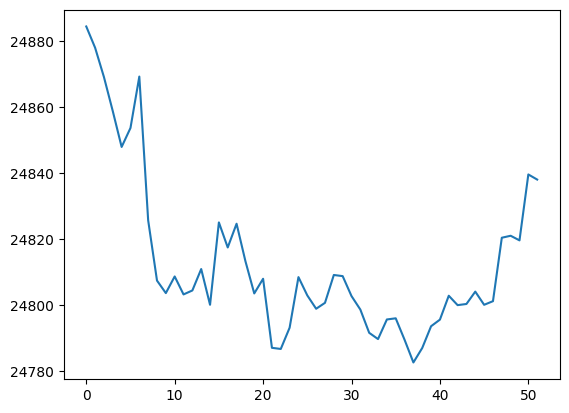

In [10]:
nifty=sample.kite.historical_data(256265, "2025-05-29", "2025-05-29", "minute")
nifty_data=[(tick['date'],tick['close']) for tick in nifty]
nifty_df = pd.DataFrame(nifty_data)
nifty_df[1].plot()

In [16]:
-1.3708415901986275 +1.3683972159261182/-1.3683972159261182

-2.3708415901986273

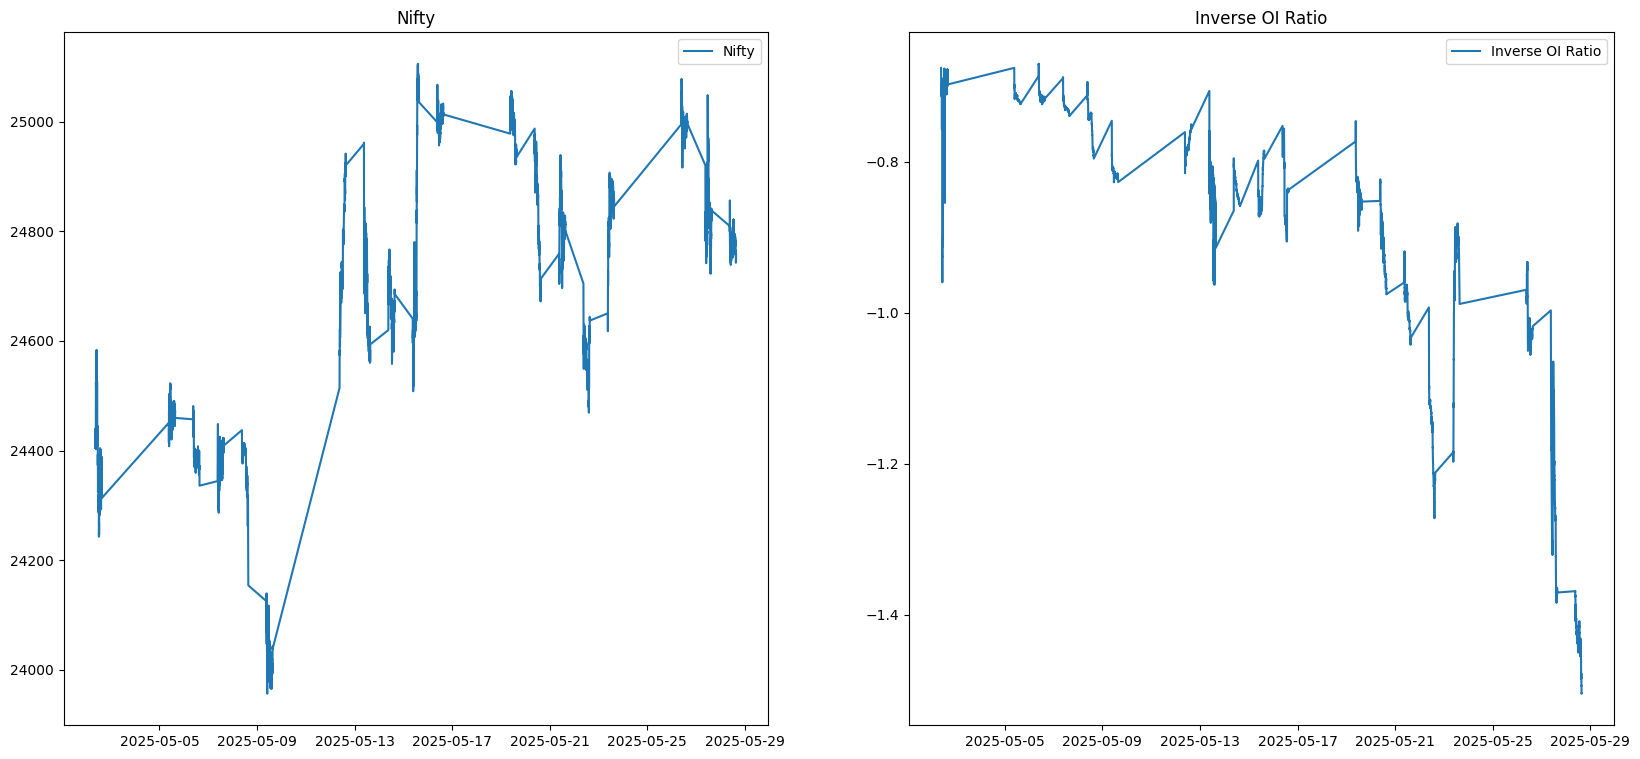

In [34]:
nifty=sample.kite.historical_data(256265, "2025-05-02", "2025-05-28", "minute")
nifty_data=[(tick['date'],tick['close']) for tick in nifty]

# plt.plot(nifty_data,label="Nifty")
# plt.plot(sample.oi_ratio,label="inverse OI ratio")
# plt.legend()

# nifty = sample.kite.historical_data(256265, "2025-05-26", "2025-05-26", "minute")
# nifty_data = [close['close'] for close in nifty]

fig, axs = plt.subplots(1, 2, figsize=(20, 9))

nifty_x,nifty_y = zip(*nifty_data)
axs[0].plot(nifty_x,nifty_y, label="Nifty")
axs[0].set_title("Nifty")
axs[0].legend()

oi_x,oi_y = zip(*sample.oi_ratio)
axs[1].plot(oi_x,oi_y, label="Inverse OI Ratio")
axs[1].set_title("Inverse OI Ratio")
axs[1].legend()

# x, y = zip(*nifty_data)

# # Plot
# plt.plot(x, y, marker='o')
# plt.xlabel('timestamp')
# plt.ylabel('Y-axis')
# plt.title('Plot from List of Tuples')
# plt.grid(True)
# plt.show()


plt.show()

In [24]:
df = pd.read_csv('/Users/sushrutkagde/Documents/Project_X/backtesting_framework/oi_strategy/oi_data/2025-05-29_oi_data.csv')
df['pct_change'] = df['Inverse OI_ratio'].pct_change()
df

,timestamp,Call oi,Put oi,Inverse OI_ratio,pct_change
0,2025-05-29 09:15:00+05:30,264484800,175143450,-1.510104,NaN
1,2025-05-29 09:16:00+05:30,264828300,176547450,-1.500040,-0.006664
2,2025-05-29 09:17:00+05:30,266100675,176764875,-1.505393,0.003569
3,2025-05-29 09:18:00+05:30,283849425,191052150,-1.485717,-0.013071
4,2025-05-29 09:19:00+05:30,284255175,191197875,-1.486707,0.000666
...,...,...,...,...,...
370,2025-05-29 15:25:00+05:30,289368000,202896600,-1.426185,-0.005386
371,2025-05-29 15:26:00+05:30,289440000,202622550,-1.428469,0.001602
372,2025-05-29 15:27:00+05:30,289439550,202464075,-1.429585,0.000781
373,2025-05-29 15:28:00+05:30,280382550,195147675,-1.436771,0.005027


<Axes: >

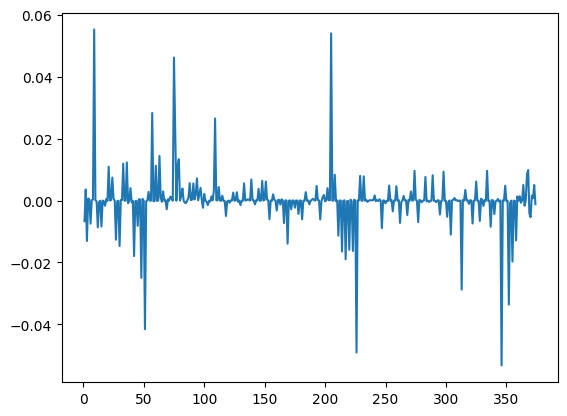

In [26]:
df['pct_change'].plot()

In [30]:
df['pct_change'].mean()

np.float64(0.0012185783182956916)

In [32]:
df['pct_change'].mean()

np.float64(0.001331570228602368)

In [36]:
df['pct_change'].mean()

np.float64(0.002106820183161161)

In [41]:
df['pct_change'].std()

np.float64(0.002801162398453568)

FileNotFoundError: [Errno 2] No such file or directory: 'a.csv'